# Task2: User Engagement Analysis

In [27]:
# import requiered python libraries

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go  
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, normalize

In [28]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from dataframe_outlier import *
from plot_data import *

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [30]:
# load and read the cleaned data
df_cleaned = pd.read_csv('../data/cleaned_Telecom_data.csv')
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      148506 non-null  int64  
 1   Unnamed:_0                      148506 non-null  int64  
 2   Bearer_Id                       148506 non-null  float64
 3   Start                           148506 non-null  object 
 4   Start_ms                        148506 non-null  int64  
 5   End                             148506 non-null  object 
 6   End_ms                          148506 non-null  int64  
 7   Dur._(ms)                       148506 non-null  int64  
 8   IMSI                            148506 non-null  float64
 9   MSISDN_Number                   148506 non-null  float64
 10  IMEI                            148506 non-null  float64
 11  Last_Location_Name              148506 non-null  object 
 12  Avg_RTT_DL_(ms) 

In [31]:
#Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric
df_user_engage =  df_cleaned[['MSISDN_Number', 'Bearer_Id', 'Dur._(ms)', 'Total_Data_(Bytes)']].copy().rename(columns={
    'Bearer_Id': 'Session_Frequency', 'MSISDN_Number':'Customer_Id', 'Dur._(ms)': 'Duration', 'Total_Data_(Bytes)': 'Total_Data_Volume'})

In [32]:
user_engage = df_user_engage.groupby('Customer_Id').agg({'Session_Frequency': 'count', 'Duration': 'sum', 'Total_Data_Volume': 'sum'})
user_engage.head(10)

,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,
33601001722.00,1,116720,878690574
33601001754.00,1,181230,156859643
33601002511.00,1,134969,595966483
33601007832.00,1,49878,422320698
33601008617.00,2,37104,1457410944
33601010682.00,2,253983,615217221
33601011634.00,2,128360,654723066
33601011959.00,1,86399,332660357
33601014694.00,2,242249,990132189


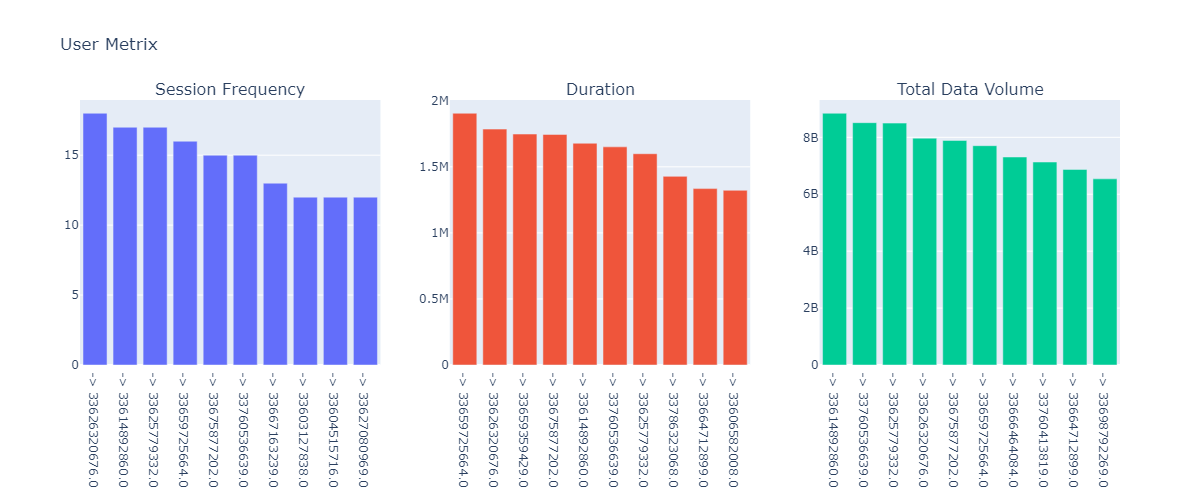

In [33]:
sessions = user_engage.nlargest(10, "Session_Frequency")['Session_Frequency']
duration = user_engage.nlargest(10, "Duration")['Duration']
total_data_volume = user_engage.nlargest(10, "Total_Data_Volume")['Total_Data_Volume']

mult_hist([sessions, duration, total_data_volume], 1,
          3, "User Metrix", ['Session Frequency', 'Duration', 'Total Data Volume'])


normalize the engagement metric and a k-means(k=3) cluturing for classification

<AxesSubplot:>

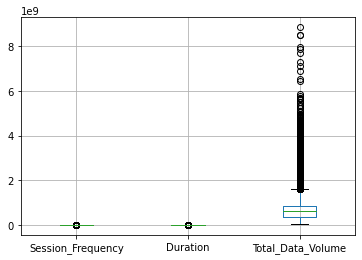

In [34]:
#check the outlier
user_engage.boxplot()

<AxesSubplot:>

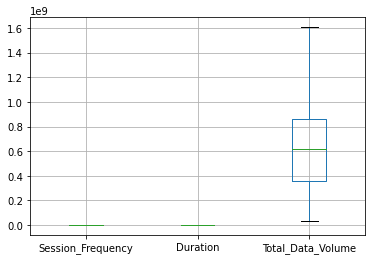

In [35]:
# removing outliers
replace_outliers_with_iqr(user_engage, ['Session_Frequency', 'Duration', 'Total_Data_Volume'])
user_engage.boxplot()

In [36]:
# Normalizing the engagement metrics
scaler = StandardScaler()
scaled_engage = scaler.fit_transform(user_engage)
pd.DataFrame(scaled_engage).head(10)

,0,1,2
0,-0.55,-0.07,0.54
1,-0.55,0.74,-1.28
2,-0.55,0.16,-0.17
3,-0.55,-0.92,-0.61
4,0.98,-1.08,2.00
5,0.98,1.66,-0.12
6,0.98,0.07,-0.02
7,-0.55,-0.46,-0.84
8,0.98,1.51,0.82
9,-0.55,0.03,0.17


In [37]:
normalized_data = normalize(scaled_engage)
pd.DataFrame(normalized_data).head(10)

,0,1,2
0,-0.71,-0.09,0.70
1,-0.35,0.47,-0.81
2,-0.92,0.26,-0.29
3,-0.45,-0.74,-0.50
4,0.39,-0.44,0.81
5,0.51,0.86,-0.06
6,1.00,0.08,-0.02
7,-0.50,-0.41,-0.76
8,0.49,0.76,0.42
9,-0.95,0.05,0.30


In [41]:
#Labeling in the k-means
k_means = KMeans(n_clusters=3, random_state=0).fit(normalized_data)
k_means.labels_

array([0, 2, 2, ..., 2, 0, 2])

In [42]:
user_engage.insert(0, 'Cluster', k_means.labels_)
user_engage.head()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
Customer_Id,,,,
33601001722.00,0,1.00,116720.00,878690574.00
33601001754.00,2,1.00,181230.00,156859643.00
33601002511.00,2,1.00,134969.00,595966483.00
33601007832.00,0,1.00,49878.00,422320698.00
33601008617.00,1,2.00,37104.00,1457410944.00


In [44]:
user_engage['Cluster'].value_counts()

2    42553
0    32375
1    31543
Name: Cluster, dtype: int64

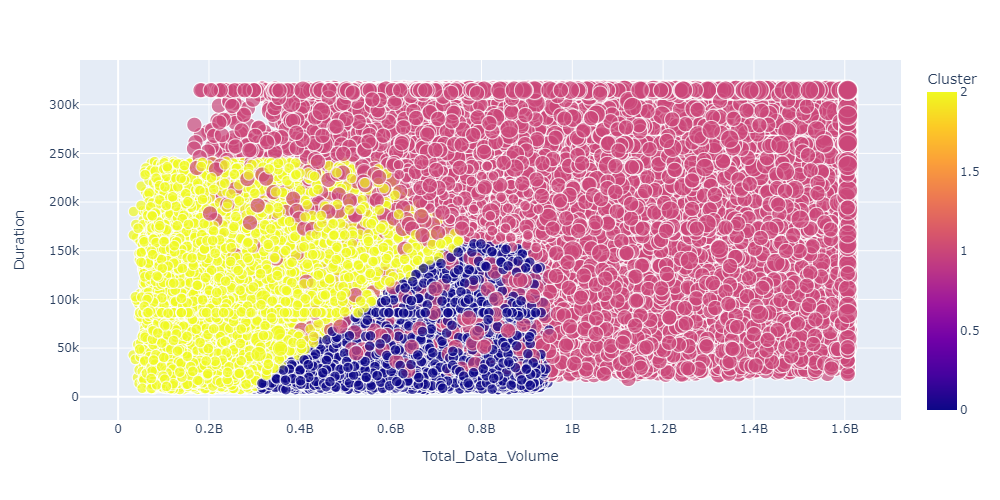

In [46]:
fig = px.scatter(user_engage, x='Total_Data_Volume', y="Duration", color='Cluster', size='Session_Frequency')
Image(pio.to_image(fig, format='png', width=1000))

Compute the minimum, maximum, average & total non-normalized metrics for each cluster.

In [47]:
cluster1 = user_engage[user_engage["Cluster"]==0]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,32375.00,32375.00,32375.00,32375.00
mean,0.00,1.00,68000.93,696153189.98
std,0.00,0.03,36927.92,143166116.22
min,0.00,1.00,7142.00,296666477.00
25%,0.00,1.00,31936.50,594192903.00
50%,0.00,1.00,82239.00,711347992.00
75%,0.00,1.00,86408.00,814160693.50
max,0.00,2.00,160546.00,950760661.00


In [49]:
cluster1 = user_engage[user_engage["Cluster"]==1]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,31543.00,31543.00,31543.00,31543.00
mean,1.00,2.21,199177.15,1090477703.19
std,0.00,0.65,84638.57,366972318.38
min,1.00,1.00,18235.00,156647546.00
25%,1.00,2.00,146426.50,808640286.00
50%,1.00,2.00,188981.00,1065126248.00
75%,1.00,2.00,271143.00,1428595485.50
max,1.00,3.50,314925.75,1606535056.25


In [50]:
cluster1 = user_engage[user_engage["Cluster"]==2]
cluster1.describe()

,Cluster,Session_Frequency,Duration,Total_Data_Volume
count,42553.00,42553.00,42553.00,42553.00
mean,2.00,1.01,107085.30,323737102.06
std,0.00,0.08,49941.68,161584869.36
min,2.00,1.00,7189.00,33249009.00
25%,2.00,1.00,85802.00,190046261.00
50%,2.00,1.00,95154.00,306337662.00
75%,2.00,1.00,145122.00,442436040.00
max,2.00,2.00,241989.00,762163252.00


Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [52]:
df_app = df_cleaned.groupby('MSISDN_Number').agg({'Gaming_(Bytes)': 'sum', 'Youtube_(Bytes)': 'sum', 'Netflix_(Bytes)': 'sum',\
                     'Google_(Bytes)': 'sum', 'Email_(Bytes)': 'sum', 'Social_Media_(Bytes)': 'sum', 'Other_(Bytes)': 'sum'})
df_app.head()

,Gaming_(Bytes),Youtube_(Bytes),Netflix_(Bytes),Google_(Bytes),Email_(Bytes),Social_Media_(Bytes),Other_(Bytes)
MSISDN_Number,,,,,,,
33601001722.00,812458661,21624548,27180981,4389005,1331362,2232135,386570872
33601001754.00,119750078,12432223,11221763,5334863,3307781,2660565,281710071
33601002511.00,538827713,21333570,19353900,3443126,3205380,3195623,501693672
33601007832.00,391126127,6977321,1942092,9678493,2284670,280294,35279702
33601008617.00,1314797820,41533002,49201724,18499616,3305469,2912542,804804484


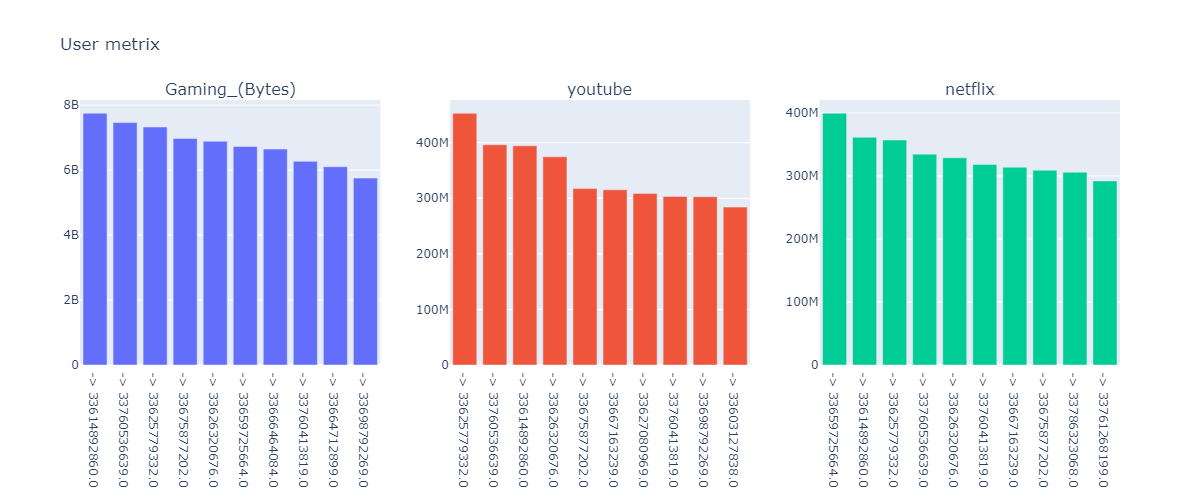

In [53]:
gaming = df_app.nlargest(10, "Gaming_(Bytes)")['Gaming_(Bytes)']
youtube = df_app.nlargest(10, "Youtube_(Bytes)")['Youtube_(Bytes)']
netflix = df_app.nlargest(10, "Netflix_(Bytes)")['Netflix_(Bytes)']
google = df_app.nlargest(10, "Google_(Bytes)")['Google_(Bytes)']
email = df_app.nlargest(10, "Email_(Bytes)")['Email_(Bytes)']
social_media = df_app.nlargest(10, "Social_Media_(Bytes)")['Social_Media_(Bytes)']
other = df_app.nlargest(10, "Other_(Bytes)")['Other_(Bytes)']


mult_hist([gaming, youtube, netflix], 1,
          3, "User metrix", ["Gaming_(Bytes)", "youtube", "netflix"])

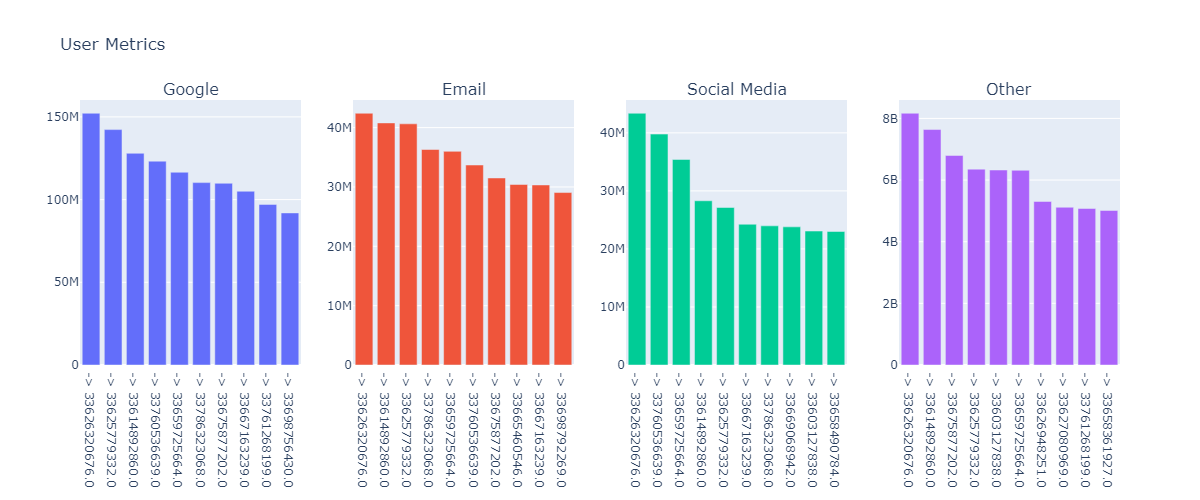

In [54]:
mult_hist([google, email, social_media, other], 1,
          4, "User Metrics", [ "Google", "Email", "Social Media", "Other"])

The most top 3 used app

In [ ]:
top_3 = app_df.sum()
top_3